In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import os
import datetime as dt
import xgboost as xgb
from sklearn.svm import OneClassSVM
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
sns.set_context("poster") 
plt.style.use('seaborn-poster')

# Install XGBoost

In [ ]:
# !pip install xgboost

# Data cleaning

In [6]:
#Top 6 biggest parks
locations = ['Rembrandtpark Noord',
 'Rembrandtpark Zuid',
 'Sarphatipark',
 'Vondelpark Oost',
 'Vondelpark West',
 'Oosterpark',
 'Erasmuspark',
 'Westergasfabriek']

resono_df = pd.read_csv('helloaimi.csv')

In [7]:
def clean_resono(df, cols, locations, merge=True):
    '''
    ~~Probably defunct once we merge the datasets~~
    Quick cleaning of the Resono data
    
    :df: Dataframe to clean
    :cols: Names of the columns to keep
    :locations: Locations to filter on
    :merge: True if Noord/Zuid and Oost/West need to be merged (default = True)
    
    Returns a cleaned Dataframe
    '''
#     resono_data = pd.read_csv(csv)
    resono_data = df[cols]
    
    # Some entries are duplicate, so we need to take the average
    df_average_visits = resono_data.copy()
    df_average_visits['Start'] = pd.to_datetime(df_average_visits['Start'])
    df_average_visits = df_average_visits.groupby(['Location', 'Start', 'End_Dates', 'End_Time']).mean().reset_index()
    df_average_visits['End'] = df_average_visits['Start'] + dt.timedelta(minutes=14, seconds=59)
    
    # Only select resono data of biggest 6 parks
    df_average_visits_parks = df_average_visits[df_average_visits['Location'].isin(locations)]

    if merge == True:
        # Merge Noord-Zuid & Oost-West into one location
        df_average_visits_parks.loc[df_average_visits_parks.Location.str.contains('Rembrandtpark'), 'Location'] = 'Rembrandtpark'
        df_average_visits_parks.loc[df_average_visits_parks.Location.str.contains('Vondelpark'), 'Location'] = 'Vondelpark'
    
    data = df_average_visits_parks.groupby(['Location', 'End', 'End_Dates', 'End_Time']).sum().reset_index()
    data = data.rename(columns = {'End' : 'Datetime',
                                  'End_Dates' : 'Date',
                                  'End_Time' : 'Time'})
    data = data.set_index('Datetime')
    return data
    
data_clean = clean_resono(resono_df, ['Location', 'Start', 'End_Dates', 'End_Time', 'Visits'], locations)
data_clean

C:\Users\lotte\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,Location,Date,Time,Visits
Datetime,,,,
2020-09-30 00:14:59+00:00,Erasmuspark,2020-09-30,00:14:59,71.0
2020-09-30 00:29:59+00:00,Erasmuspark,2020-09-30,00:29:59,56.0
2020-09-30 00:44:59+00:00,Erasmuspark,2020-09-30,00:44:59,41.5
2020-09-30 00:59:59+00:00,Erasmuspark,2020-09-30,00:59:59,55.5
2020-09-30 01:14:59+00:00,Erasmuspark,2020-09-30,01:14:59,33.5
...,...,...,...,...
2020-11-12 11:59:59+00:00,Westergasfabriek,2020-11-12,11:59:59,1881.0
2020-11-12 12:14:59+00:00,Westergasfabriek,2020-11-12,12:14:59,1501.0
2020-11-12 12:29:59+00:00,Westergasfabriek,2020-11-12,12:29:59,1204.0


# Data preprocessing

In [131]:
def add_time_vars(data, onehot=True):
    '''
    Adds columns for the month and weekday, and also the one-hot encoding or the cyclical versions of those features.

    :data: Dataframe that contains the a column with the datetime
    :onehot: Use onehot encoding if true and cyclical features if false (default = True)
    
    Returns a Dataframe with either the one-hot encoding or the sine and cosine of the month, weekday and time added
    '''
    data = data.reset_index()
    if onehot == True:
        data['Month'] = pd.Categorical(data['Datetime'].dt.month)
        data['Weekday'] = pd.Categorical(data['Datetime'].dt.weekday)
        data['Hour'] =  pd.Categorical(data['Datetime'].dt.hour)
        data['Minute'] =  pd.Categorical(data['Datetime'].dt.minute)

        month_dummies = pd.get_dummies(data[['Month']], prefix='Month_')
        weekday_dummies = pd.get_dummies(data[['Weekday']], prefix='Weekday_')
        hour_dummies = pd.get_dummies(data[['Hour']], prefix='Hour_')
        minute_dummies = pd.get_dummies(data[['Minute']], prefix='Minute_')
        
        data = data.merge(month_dummies, left_index = True, right_index = True)
        data = data.merge(weekday_dummies, left_index = True, right_index = True)
        data = data.merge(hour_dummies, left_index = True, right_index = True)
        data = data.merge(minute_dummies, left_index = True, right_index = True)
        
    else: 
        dates = data['Date'].values
        weekdays = []
        months = []
        hours = []
        minutes = []

        for d in dates:
            year, month, day = (int(x) for x in d.split('-'))
            ans = dt.date(year, month, day)
            weekdays.append(ans.isocalendar()[2])
            months.append(month)

        for t in data['Time']:
            hour, minute, second = (int(x) for x in t.split(':'))
            hours.append(hour)
            minutes.append(minute)
        
        data['Weekday'] = weekdays
        data['Month'] = months
        data['Hour'] = hours
        data['Minute'] = minutes
        data['Weekday_sin'] = np.sin(data['Weekday'] * (2 * np.pi / 7))
        data['Weekday_cos'] = np.cos(data['Weekday'] * (2 * np.pi / 7))
        data['Month_sin'] = np.sin(data['Month'] * (2 * np.pi / 12))
        data['Month_cos'] = np.cos(data['Month'] * (2 * np.pi / 12))
        data['Hour_sin'] = np.sin(data['Hour'] * (2 * np.pi / 24))
        data['Hour_cos'] = np.cos(data['Hour'] * (2 * np.pi / 24))
        data['Minute_sin'] = np.sin(data['Minute'] * (2 * np.pi / 60))
        data['Minute_cos'] = np.cos(data['Minute'] * (2 * np.pi / 60))
        
    data = data.set_index('Datetime')
    return data

data_aug = add_time_vars(data_clean, onehot=True)
data_aug

,Location,Date,Time,Visits,Month,Weekday,Hour,Minute,Month__9,Month__10,...,Hour__18,Hour__19,Hour__20,Hour__21,Hour__22,Hour__23,Minute__14,Minute__29,Minute__44,Minute__59
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-09-30 00:14:59+00:00,Erasmuspark,2020-09-30,00:14:59,71.0,9,2,0,14,1,0,...,0,0,0,0,0,0,1,0,0,0
2020-09-30 00:29:59+00:00,Erasmuspark,2020-09-30,00:29:59,56.0,9,2,0,29,1,0,...,0,0,0,0,0,0,0,1,0,0
2020-09-30 00:44:59+00:00,Erasmuspark,2020-09-30,00:44:59,41.5,9,2,0,44,1,0,...,0,0,0,0,0,0,0,0,1,0
2020-09-30 00:59:59+00:00,Erasmuspark,2020-09-30,00:59:59,55.5,9,2,0,59,1,0,...,0,0,0,0,0,0,0,0,0,1
2020-09-30 01:14:59+00:00,Erasmuspark,2020-09-30,01:14:59,33.5,9,2,1,14,1,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-12 11:59:59+00:00,Westergasfabriek,2020-11-12,11:59:59,1881.0,11,3,11,59,0,0,...,0,0,0,0,0,0,0,0,0,1
2020-11-12 12:14:59+00:00,Westergasfabriek,2020-11-12,12:14:59,1501.0,11,3,12,14,0,0,...,0,0,0,0,0,0,1,0,0,0
2020-11-12 12:29:59+00:00,Westergasfabriek,2020-11-12,12:29:59,1204.0,11,3,12,29,0,0,...,0,0,0,0,0,0,0,1,0,0


In [122]:
def remove_outliers(df, gamma=0.01, nu=0.03):
    '''
    Remove outliers with a One-Class SVM.
    
    :df: Dataframe to perform outlier detection on
    :gamma: Value of the kernel coefficient for ‘rbf’ (default = 0.01)
    :nu: Percentage of the data to be classified as outliers (default = 0.03)
    
    Returns
    :df_detected: Dataframe with the outliers replaced by NaN
    :outlier_index: List of the indexes of the outliers (used for plotting the outliers, probably 
                                                         not necessary for final product)
    '''
    SVM_models = []
    model = OneClassSVM(kernel='rbf', gamma=gamma, nu=nu)
    df_detected = df.copy()
    
    for idx, loc in enumerate(df.columns):
        dt = df[loc]
        dt_detected = dt.copy()
        
        scaler = preprocessing.StandardScaler()
        dt_scaled = scaler.fit_transform(dt.values.reshape(-1,1))
            
        fit = model.fit(dt_scaled)
        pred = fit.predict(dt_scaled)
        outlier_index = np.where(pred == -1)
        
        if len(outlier_index) != len(dt_detected):
            dt_detected.iloc[outlier_index] = np.nan
    
        df_detected[loc] = dt_detected
        
    return df_detected, outlier_index

test, outlier_idx = remove_outliers(data_clean[['Visits']])
test

,Visits
Datetime,
2020-09-30 00:14:59+00:00,71.0
2020-09-30 00:29:59+00:00,56.0
2020-09-30 00:44:59+00:00,41.5
2020-09-30 00:59:59+00:00,55.5
2020-09-30 01:14:59+00:00,33.5
...,...
2020-11-12 11:59:59+00:00,1881.0
2020-11-12 12:14:59+00:00,1501.0
2020-11-12 12:29:59+00:00,1204.0


<AxesSubplot:xlabel='Datetime', ylabel='Visits'>

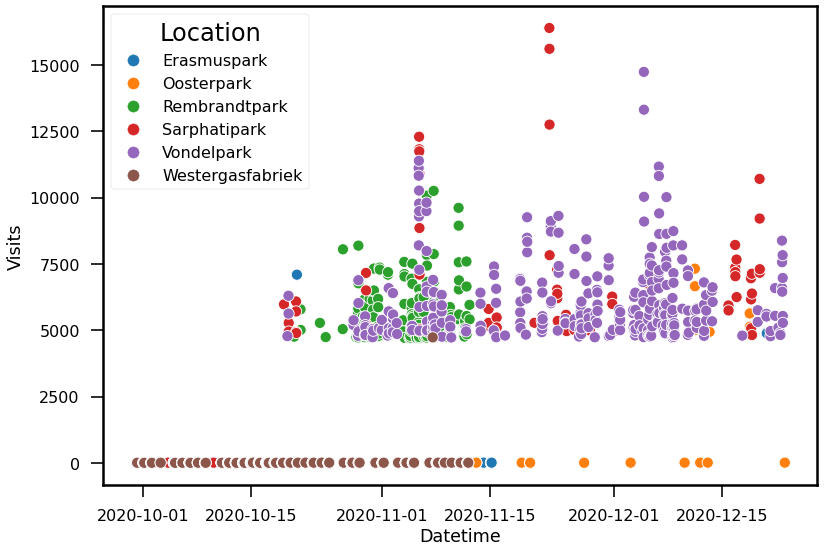

In [123]:
outliers = data_clean.iloc[outlier_idx]
sns.scatterplot(x="Datetime", y="Visits", hue="Location", data=outliers)

<AxesSubplot:xlabel='Datetime', ylabel='Visits'>

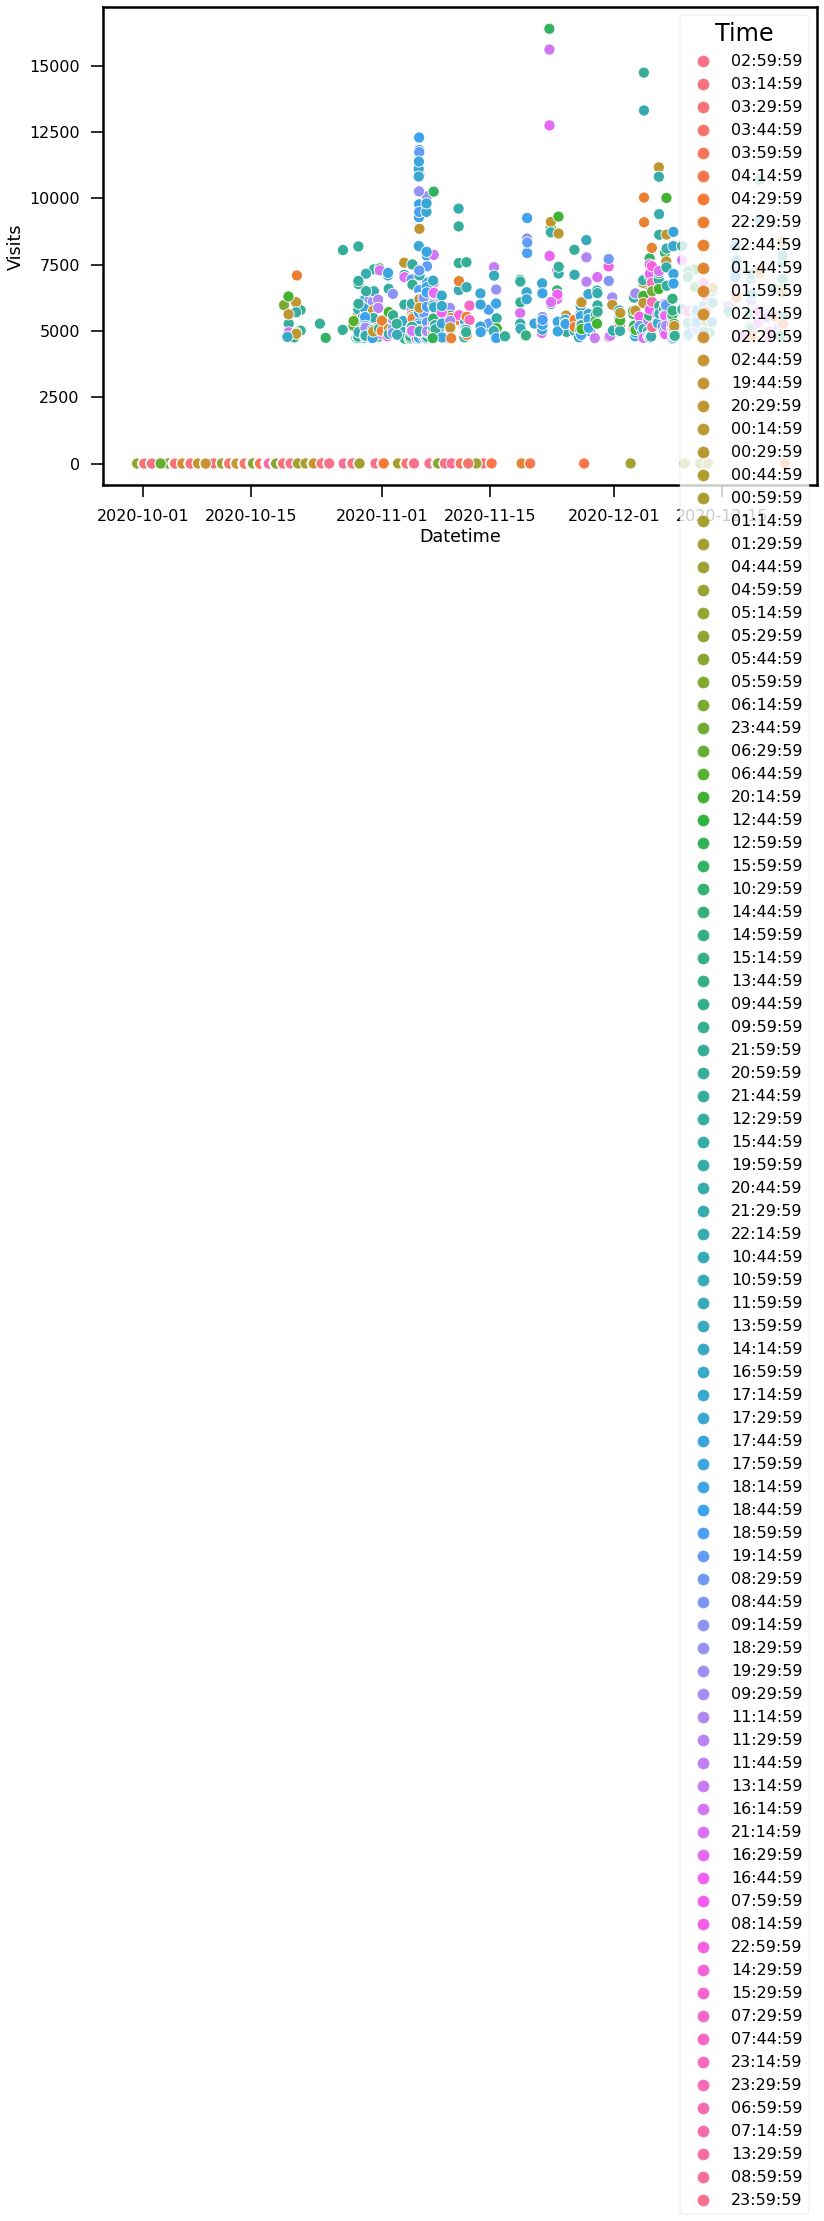

In [124]:
sns.scatterplot(x="Datetime", y="Visits", hue="Time", data=outliers)

In [125]:
def interpolate_df(df, backfill=False):
    '''
    Interpolate the NaN values in the dataframe with either backfilling or linear interpolation.
    
    :df: Dataframe to be interpolated
    :backfill: Bool, if true, interpolate with backfilling, otherwise use linear interpolation (default = False)
    
    Returns a Dataframe with interpolated values
    '''
    df_int = df.copy()
    
    if backfill == True:
        df_int = df_int.backfill()
        
    else:
        for idx, loc in enumerate(df.columns):
            dt = df[loc]
            dt_int = dt.copy()
            dt_int = dt_int.interpolate()
            df_int[loc] = dt_int
        
    return df_int

test_int = interpolate_df(test, backfill=False)
test_int.iloc[outlier_idx]

,Visits
Datetime,
2020-09-30 02:59:59+00:00,31.416667
2020-10-16 03:14:59+00:00,23.357143
2020-10-16 03:29:59+00:00,33.047619
2020-10-16 03:44:59+00:00,42.738095
2020-10-16 03:59:59+00:00,52.428571
...,...
2020-11-12 02:44:59+00:00,14.000000
2020-11-12 02:59:59+00:00,13.000000
2020-11-12 03:14:59+00:00,12.000000


In [126]:
def smooth_df(df, N=3):
    '''
    Smooth the data with a rolling average to remove false peaks in the data
    
    :df: Dataframe to be smoothed
    :N: Size of the moving window (default = 3)
    
    Returns a smoothed Dataframe
    '''
    df_smooth = df.copy()
    df_smooth = df_smooth.rolling(N).mean()
    
    begin_vals = df.iloc[:N-1]
    df_smooth.update(begin_vals)
        
    return df_smooth

data_smooth = smooth_df(data_clean)
data_smooth

,Visits
Datetime,
2020-09-30 00:14:59+00:00,71.000000
2020-09-30 00:29:59+00:00,56.000000
2020-09-30 00:44:59+00:00,56.166667
2020-09-30 00:59:59+00:00,51.000000
2020-09-30 01:14:59+00:00,43.500000
...,...
2020-11-12 11:59:59+00:00,2056.666667
2020-11-12 12:14:59+00:00,1871.333333
2020-11-12 12:29:59+00:00,1528.666667


# Predictions with XGBoost

In [132]:
data_aug.columns.to_list()[8:]

['Month__9',
 'Month__10',
 'Month__11',
 'Month__12',
 'Weekday__0',
 'Weekday__1',
 'Weekday__2',
 'Weekday__3',
 'Weekday__4',
 'Weekday__5',
 'Weekday__6',
 'Hour__0',
 'Hour__1',
 'Hour__2',
 'Hour__3',
 'Hour__4',
 'Hour__5',
 'Hour__6',
 'Hour__7',
 'Hour__8',
 'Hour__9',
 'Hour__10',
 'Hour__11',
 'Hour__12',
 'Hour__13',
 'Hour__14',
 'Hour__15',
 'Hour__16',
 'Hour__17',
 'Hour__18',
 'Hour__19',
 'Hour__20',
 'Hour__21',
 'Hour__22',
 'Hour__23',
 'Minute__14',
 'Minute__29',
 'Minute__44',
 'Minute__59']

In [133]:
def predict(data, location, pred_params, N_boost=100):
    '''
    Predict the amount of visits using XGBoost
    
    :data: Dataframe with all the data
    :location: The location of the park to make predictions for
    :pred_params: A list of the names of the predictor variables
    :N_boost: Number of boost rounds during training (default = 100)
    
    Returns nothing (yet)
    '''
    # Select data for a specific park
    data = data[data['Location'] == location]

    # Split the data into input and output variables
    X = data[pred_params]
    y = data['Visits']

    # Split the data into test and train sets
    train_X, test_X, train_y, test_y = train_test_split(X, y,
                          test_size = 0.3, random_state = 123)

    # Convert test and train set to DMatrix objects
    train_dmatrix = xgb.DMatrix(data = train_X, label = train_y)
    test_dmatrix = xgb.DMatrix(data = test_X, label = test_y)
    
    # Set parameters for base learner
    params = {
        'booster': 'gblinear',
#         'colsample_bynode': 0.8,
        'learning_rate': 1,
#         'max_depth': 15,
#         'num_parallel_tree': 100,
        'objective': 'reg:squarederror',
#         'subsample': 0.8,
#         'tree_method': 'gpu_hist'
    }

    # Fit the data and make predictions
    model = xgb.train(params = params, dtrain = train_dmatrix, num_boost_round = N_boost)
    pred = model.predict(test_dmatrix)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test_y, pred))
    print("RMSE : % f" %(rmse))
    

predictor_cols = data_aug.columns.to_list()[8:]
predict(data_aug, 'Vondelpark', predictor_cols, 1000)

RMSE :  1037.623203
